# Predicting Customer Churn

In [1]:
import pandas as pd
import numpy as np
import os
import scipy.stats as stats

# Viz imports
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling imports
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Custom module imports
import acquire
import prepare
import explore

### Executive Summary

- My goal is to create a model to predict customers likely to churn
    - This can help reduce churn rate and increase customer retention

### Key Takeaways
- Overall churn rate is at 27%
- Monthly charges for customers who churn are 21% higher than customers who don't churn
- Month to month contracts had the highest number of churning customers
- My best model used Logistic Regression to predict customers who will churn with 80% accuracy. This model outperformed my baseline score of 73.47% accuracy, so it has value.

### Project Overview
- Trello board used to identify the different tasks for this project. You can find the board <a href="https://trello.com/b/lU0bjeXw/predicting-customer-churn">here</a>
- Python scripts were used to acquire, prepare and explore the data
- All the models predicted churn with an accuracy higher than the baseline model
- Statistical analyses tested the following hypotheses:
    1. Mean monthly charges of customers who churned
    2. Churning is independent of having fiber optic internet
    3. Churning is independent of payment type
    4. There is no linear correlation between tenure and monthly charges
 
### Data Dictionary
The data dictionary detailing all variables utilized in this analyses can be found <a href="https://github.com/mariamnaqvi/predicting_customer_churn/blob/main/README.md">here</a>.

# Acquire Data


In [2]:
# set options to display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
# acquire telco data into a dataframe
telco_df = acquire.get_telco_data()

In [4]:
# Quick look at the first 5 rows of our dataset
telco_df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,3,0016-QLJIS,Female,0,Yes,Yes,65,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,90.45,5957.9,No,Two year,DSL,Mailed check
1,4,1,3,0017-DINOC,Male,0,No,No,54,No,No phone service,Yes,No,No,Yes,Yes,No,No,45.20,2460.55,No,Two year,DSL,Credit card (automatic)
2,3,1,3,0019-GFNTW,Female,0,No,No,56,No,No phone service,Yes,Yes,Yes,Yes,No,No,No,45.05,2560.1,No,Two year,DSL,Bank transfer (automatic)
3,4,1,3,0056-EPFBG,Male,0,Yes,Yes,20,No,No phone service,Yes,No,Yes,Yes,No,No,Yes,39.40,825.4,No,Two year,DSL,Credit card (automatic)
4,3,1,3,0078-XZMHT,Male,0,Yes,No,72,Yes,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,85.15,6316.2,No,Two year,DSL,Bank transfer (automatic)


Takeaways:

- Most variables seem to be categorical
    
- Only continuous variables are: monthly charges and total charges
    
- Each row represents a customer and provides service and demographic information
 

In [5]:
# Check the different classes in each variable
telco_df.nunique()


payment_type_id                4
internet_service_type_id       3
contract_type_id               3
customer_id                 7043
gender                         2
senior_citizen                 2
partner                        2
dependents                     2
tenure                        73
phone_service                  2
multiple_lines                 3
online_security                3
online_backup                  3
device_protection              3
tech_support                   3
streaming_tv                   3
streaming_movies               3
paperless_billing              2
monthly_charges             1585
total_charges               6531
churn                          2
contract_type                  3
internet_service_type          3
payment_type                   4
dtype: int64

Takeaways:
- Customer id, tenure, monthly charges and total charges do not seem to be categorical
    - These values seem to be somewhat unique to each customer
    - Therefore, there is no value in displaying value counts for these variables

In [6]:
# describes the df, object and numeric cols
acquire.get_data_summary(telco_df)

The telco dataframe has 7043 rows and 24 columns.

-------------------
There are total of 0 missing values in the entire dataframe.

-------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   payment_type_id           7043 non-null   int64  
 1   internet_service_type_id  7043 non-null   int64  
 2   contract_type_id          7043 non-null   int64  
 3   customer_id               7043 non-null   object 
 4   gender                    7043 non-null   object 
 5   senior_citizen            7043 non-null   int64  
 6   partner                   7043 non-null   object 
 7   dependents                7043 non-null   object 
 8   tenure                    7043 non-null   int64  
 9   phone_service             7043 non-null   object 
 10  multiple_lines            7043 non-null   object 
 11  online_security     

## Acquire Takeaways
- Churn is our target variable
- There are 7043 rows and 24 columns
- Some columns convey the same information. In the following cases, the non-numeric column will be dropped:
    - payment_type_id == payment type. Retain payment_type_id 
    - internet_service_type_id == internet_service_type. Retain internet_service_type_id  
    - contract_type_id == contract_type. Retain contract_type_id 
- The following binary categorical columns will be encoded to a numeric dtype
    - gender 
    - partner 
    - dependents 
    - paperless_billing 
- The phone service column has values of 'No' and 'No phone service' which are redundant. These outcomes will both be encoded as 0.  
- The following categorical columns have outcomes of 'Yes', 'No', 'No internet/phone service'. For the analysis, the latter two will be grouped together and new columns for internet and phone service will indicate if a customer has either of those services. 
    - multiple_lines
    - online_security
    - online_backup
    - device_protection
    - tech_support
    - streaming_tv
    - streaming_movies
- The total_charges column has an object dtype - will be changed to float for statistical analysis
- The customer_id column is not particulary useful but is needed to provide predictions. This column will be retained but not utilized in the analysis

# Prepare Data

Before operating on the data, let's visualize individual distributions

In [7]:
# Defining the categorical and quantitative variables
only_cat = telco_df.drop(columns=['tenure','monthly_charges',
 'total_charges'])
cat_vars1 = only_cat.columns.to_list()
quant_vars1 = ['tenure','monthly_charges',
 'total_charges']

## Explore Univariate Distributions
The explore_univariate function from my explore script is used to create bar plots for categorical variables and histograms for quantitative variables

Bar Plot of payment_type_id


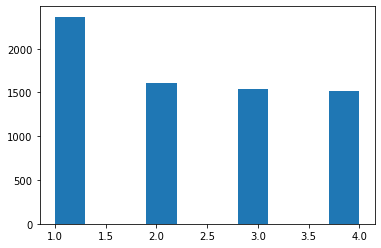

Bar Plot of internet_service_type_id


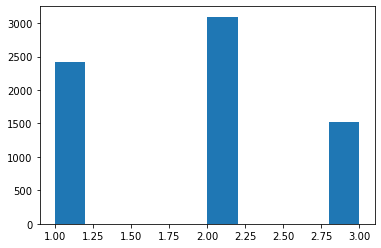

Bar Plot of contract_type_id


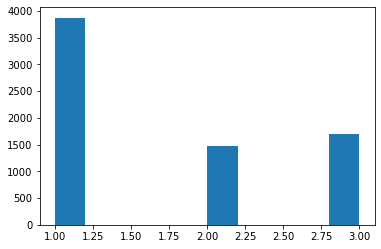

Bar Plot of customer_id


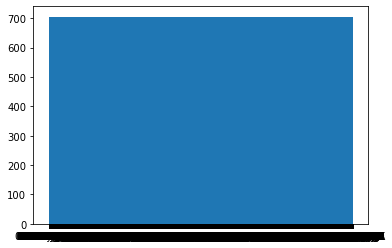

Bar Plot of gender


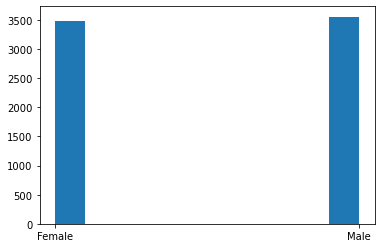

Bar Plot of senior_citizen


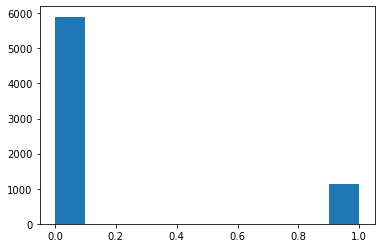

Bar Plot of partner


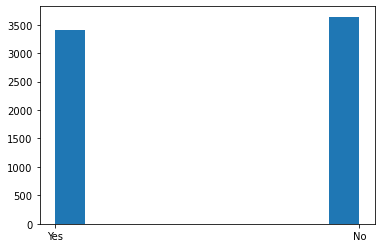

Bar Plot of dependents


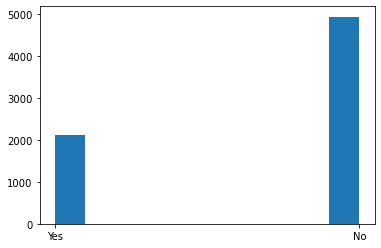

Bar Plot of phone_service


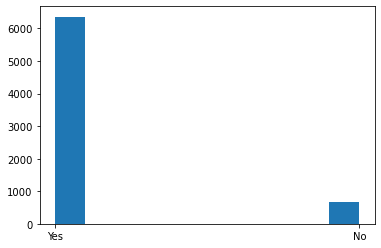

Bar Plot of multiple_lines


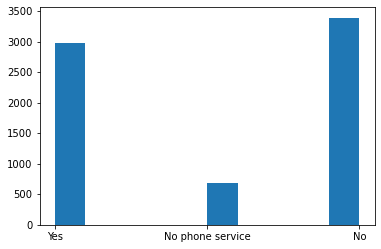

Bar Plot of online_security


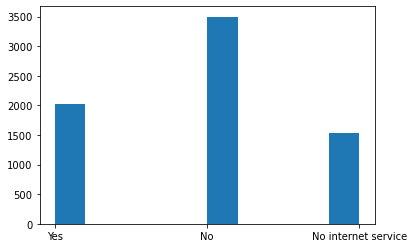

Bar Plot of online_backup


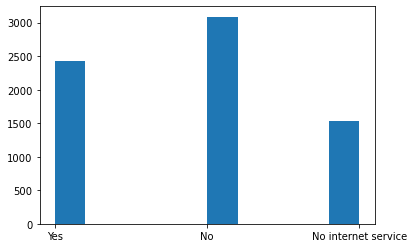

Bar Plot of device_protection


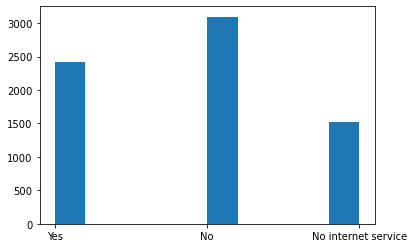

Bar Plot of tech_support


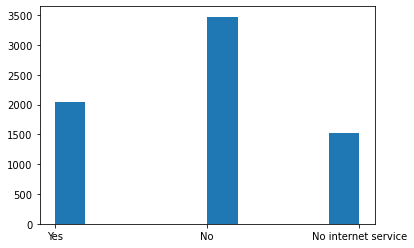

Bar Plot of streaming_tv


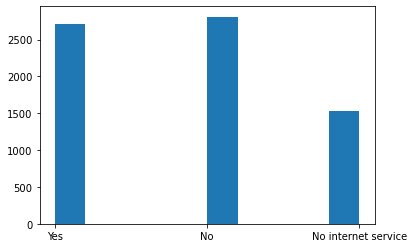

Bar Plot of streaming_movies


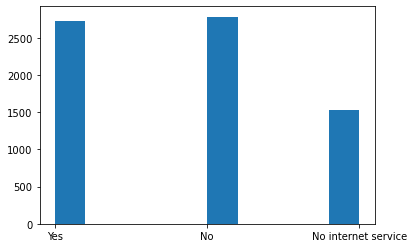

Bar Plot of paperless_billing


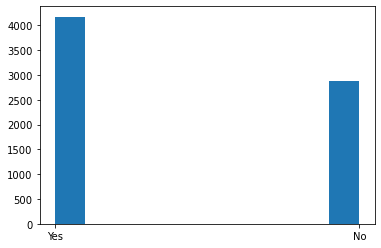

Bar Plot of churn


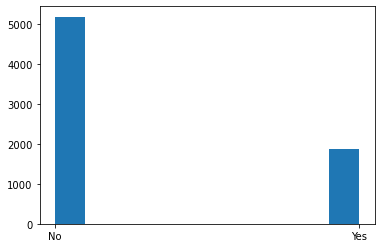

Bar Plot of contract_type


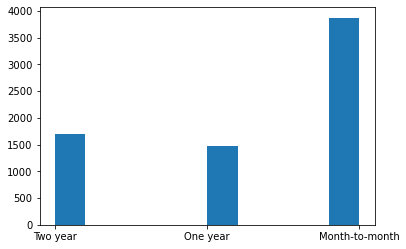

Bar Plot of internet_service_type


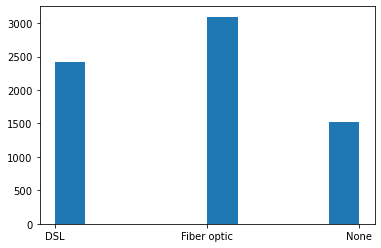

Bar Plot of payment_type


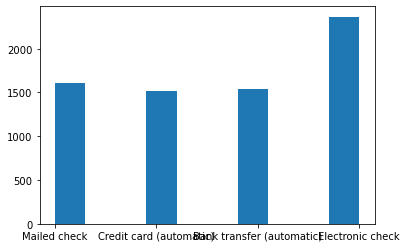

Distribution of tenure


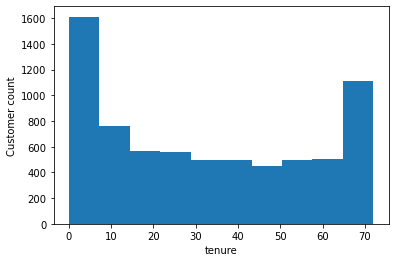

Distribution of monthly_charges


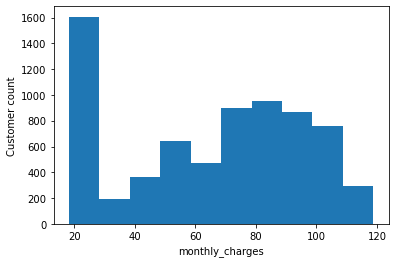

Distribution of total_charges


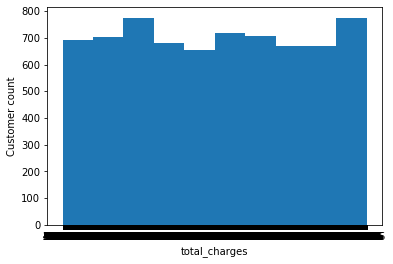

In [8]:
explore.explore_univariate(telco_df, cat_vars1, quant_vars1)

### Observations from original data

- Most customers:
    - use payment type 1 which is Electronic check 
    - have fiber optic internet followed by those with DSL
    - have month to month contracts whereas the remaining customers are evenly split among 1 and 2 year contracts
    - are not seniors
    - do not have dependents
    - have phone service but don't have multiple lines
    - don't use online security, online backup, device protection, tech support
    - use paperless billing
    - did not churn
    - had shorter tenures and lower monthly charges
- Customer genders are fairly even 
- There is almost the same proportion of customers with and without partners
- Similar numbers of customers use tech support and online security
- Similar numbers of customers use online backup and device protection
- Proportions of customers who stream and don't is quite similar
- Tenure is not normally distributed 
    - majority of customers have very short or very long tenures
- Monthly charges is somewhat normally distributed, with a peak at lowest monthly charges
- The distribution of total charges is almost uniform

### Data Cleaning 

> While converting total_charges to floats, I found that the total_charges column contained 11 rows with empty string values.

In [9]:
# shows the empty string values in the total_charges column
telco_df.total_charges.value_counts(dropna=False).head()

20.2     11
         11
19.75     9
20.05     8
19.9      8
Name: total_charges, dtype: int64

In [10]:
# examine records where total charges is empty string
telco_df[['tenure','monthly_charges', 'total_charges']][(telco_df.total_charges == ' ')]

,tenure,monthly_charges,total_charges
85,0,56.05,
156,0,61.90,
236,0,73.35,
255,0,52.55,
339,0,80.85,
5681,0,20.00,
5717,0,20.25,
5727,0,25.35,
5798,0,25.75,
6007,0,19.85,


Note:
    
- In every instance, that the total_charges field is empty, the tenure is found to be 0. This indicates that these are new customers who have been with the company for under a month of tenure. 
    - Their total charges will be equal to their monthly charges
    
    
- The empty strings were replaced with NaN values which were then filled with the monthly_charges values.

- Finally the total_charges column was converted to a float dtype as part of the prepare script

### New Features created

1. en_contract_type

This variable was encoded for better readability

 - 0: Month to month contracts
 - 1: 1 year contracts
 - 2: 2 year contracts
    
2. en_monthly_contract

This variable was created to explore the relationship between month to month contracts and churn

   - 1: Month to month contracts
   - 0: 1 and 2 year contracts
   
3. en_has_fiber

This variable was created to explore the relationship between fiber optic customers and churn

- 1: Fiber optic
- 0: DSL and none

4. has_internet

This variable was created to explore the relationship between having internet service and churn

- 1: Fiber optic or DSL
- 0: None

### One hot encoded features

The following variables were one hot encoded, renamed for better readability and then the redundant columns were dropped.

- gender 
- partner
- dependents
- phone_service
- paperless_billing
- churn

In addition to the aforementioned columns, the following columns were also dropped as indicated in the acquire stage:

- internet_service_type_id
- multiple_lines
- contract_type_id
- payment_type
- online_security

### Splitting the dataset

In [7]:
# calling the prepare function
train, validate, test = prepare.prep_telco_data(telco_df)

There are no duplicate rows in your dataset.
----------------
The empty string values have been filled with monthly_charges values
Total charges has been converted from object to a float data type.
----------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3943 entries, 5642 to 6840
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   payment_type_id        3943 non-null   int64  
 1   customer_id            3943 non-null   object 
 2   senior_citizen         3943 non-null   int64  
 3   tenure                 3943 non-null   int64  
 4   monthly_charges        3943 non-null   float64
 5   total_charges          3943 non-null   float64
 6   en_contract_type       3943 non-null   int64  
 7   en_monthly_contract    3943 non-null   int64  
 8   en_multiple_lines      3943 non-null   int64  
 9   en_has_fiber           3943 non-null   int64  
 10  en_has_DSL             3943 non-null   int64  

## Prepare Takeaways
- Although the dataset was pretty clean, I performed the steps identified in the acquire stage (encoding, checking for missing values, mapping, conversion to float)
- Redundant columns were removed altogether
- I checked for duplicate rows - none were found
- I split the original dataframe into train, validate and test utilizing a random seed of 123 and stratified on the target variable of churn:
    - Train: 56% of the df
    - Validate: 24% of the df
    - Test: 20% of the df
- Each of the train, validate and test splits have 24 columns

# Explore Data

In [12]:
# setting rc parameters for visualizations
plt.rc('font', size=14)
plt.rc('figure', figsize=(14, 8))

In [8]:
# checking overall churn across all customers in train split
train.churned.value_counts()

0    2897
1    1046
Name: churned, dtype: int64

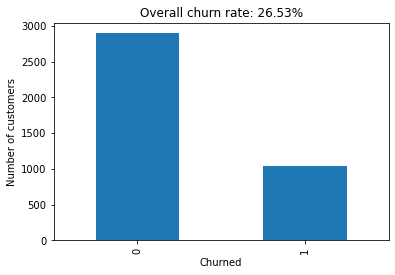

In [9]:
# visualizing overall churn rate
# 0 = No, 1 = yes on the x axis
train.churned.value_counts().sort_index().plot.bar()
churn_rate = train.churned.mean()
plt.title(f'Overall churn rate: {churn_rate:.2%}')
plt.xlabel('Churned')
plt.ylabel('Number of customers')
plt.show()

### Takeaways
- Overall churn rate is not very high
- However, we want to explore ways to reduce churn so we can retain customers and maximize revenue

### Exploring Bivariate Relationships

- The explore_bivariate function from the explore script takes in lists of categorical and quantitative variables. It creates barplots, countplots and boxplots.

- The bar plot shows the churn rate for each class in each category
    - The dotted line is the average overall churn rate
- The countplots show the number of customers who churned and did not churn for each class in each category
- The boxplots show the relationship between quantitative variables of monthly charges, total charges and tenure and each class of churn

In [10]:
# Define New Categorical variables 
cat_vars = ['payment_type_id','senior_citizen','en_contract_type',
'en_multiple_lines','en_has_fiber','en_has_DSL','has_internet',
'en_online_security','en_online_backup','en_device_protection',
'en_tech_support','en_streaming_tv','en_streaming_movies',
'gender_female','has_partner','has_dependents','has_phone_service',
'has_paperless_billing', 'en_monthly_contract']

In [11]:
# Define quantitative variables
quant_vars = ['monthly_charges','total_charges','tenure']

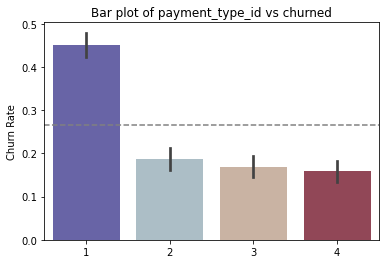

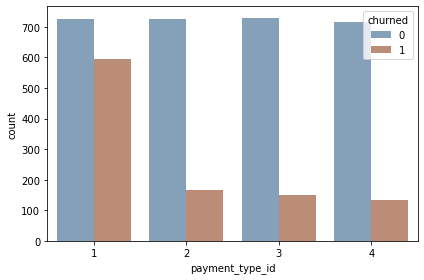

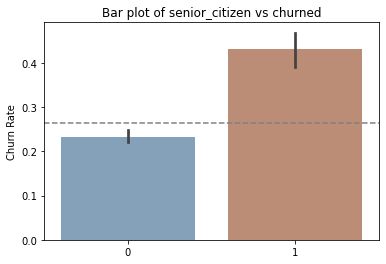

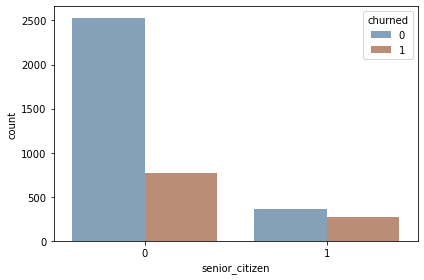

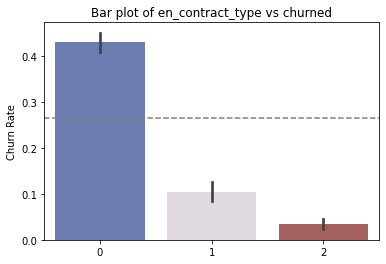

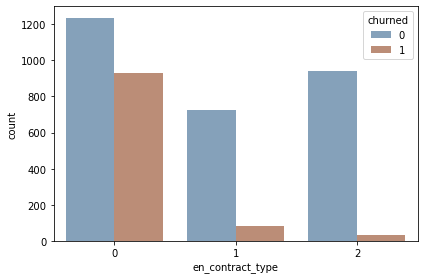

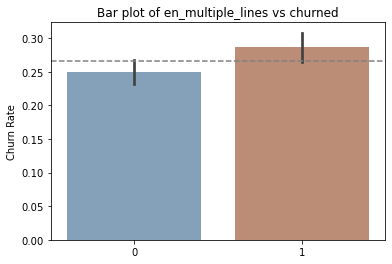

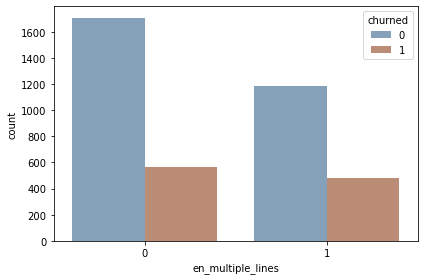

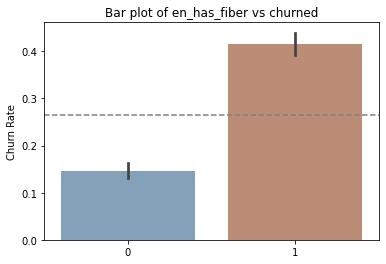

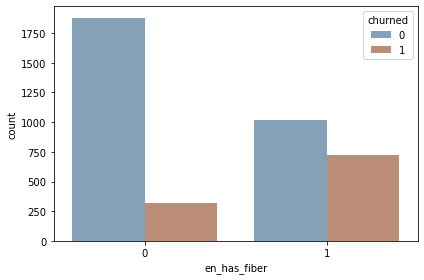

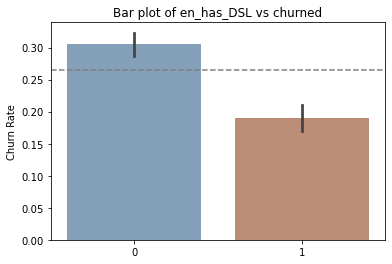

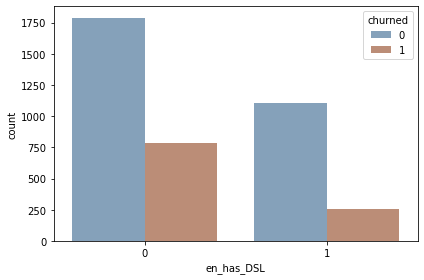

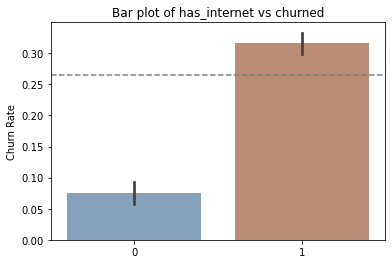

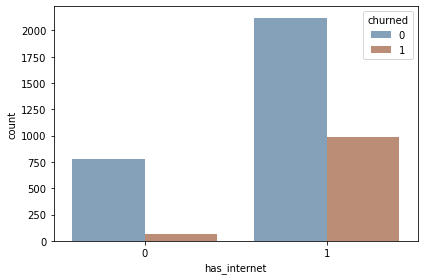

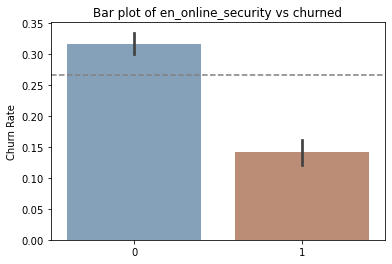

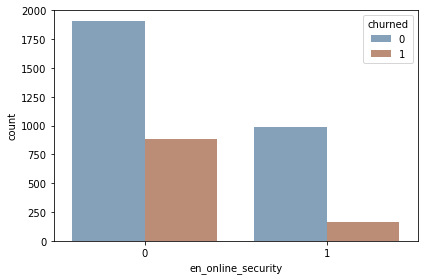

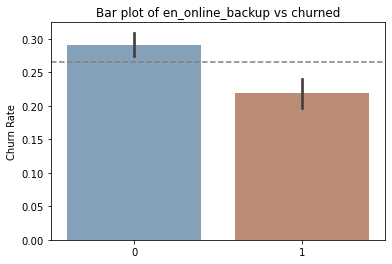

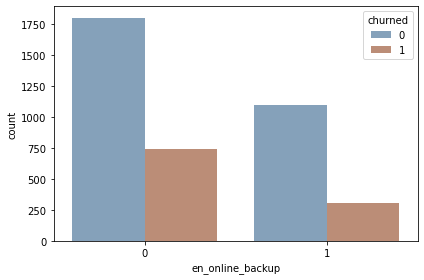

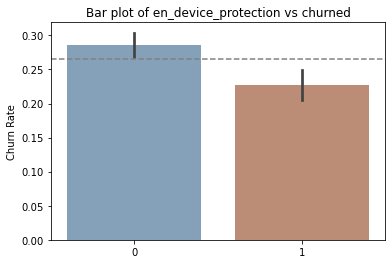

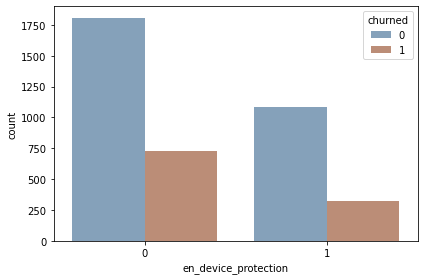

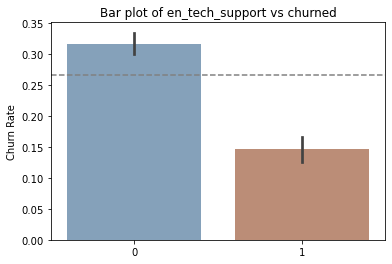

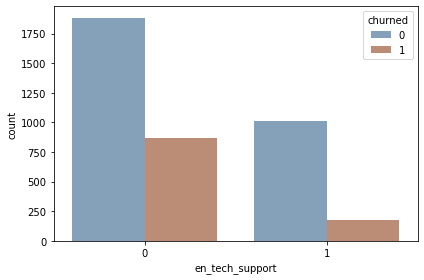

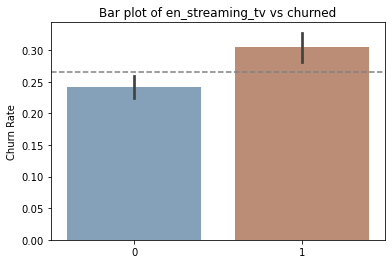

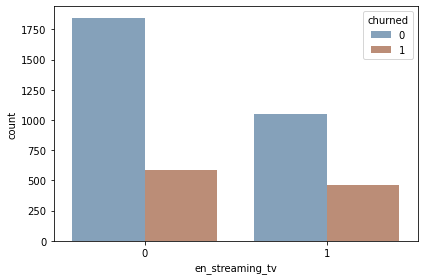

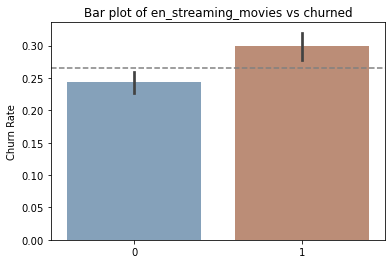

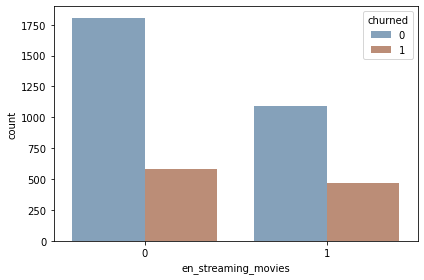

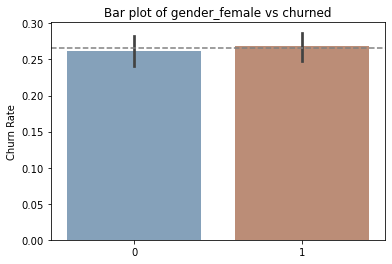

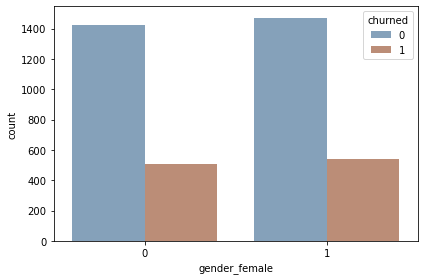

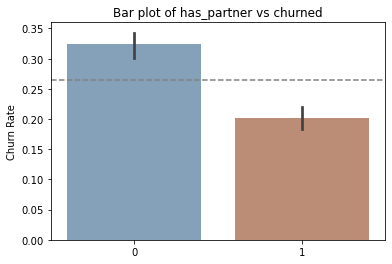

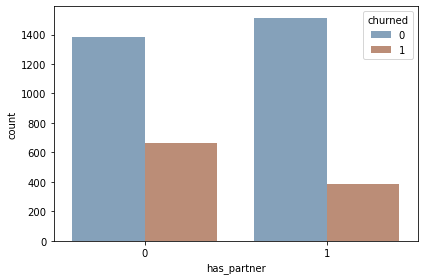

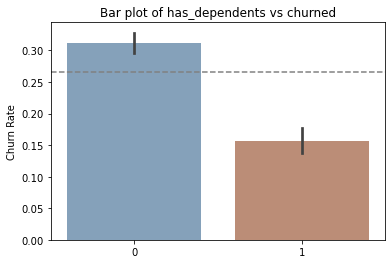

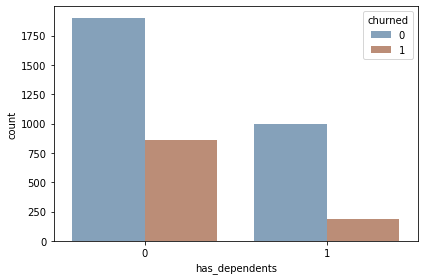

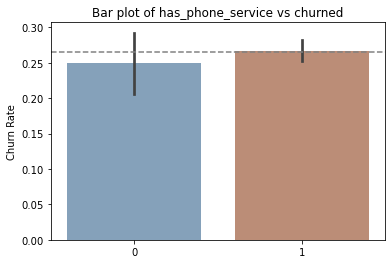

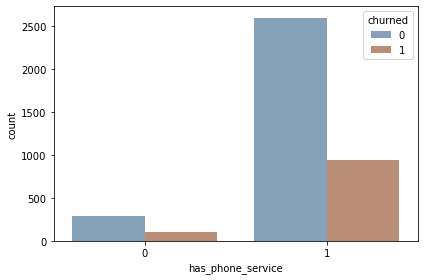

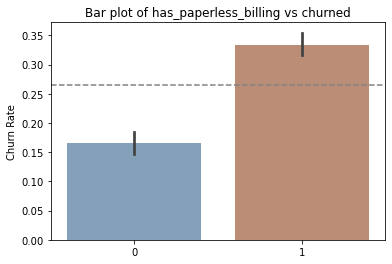

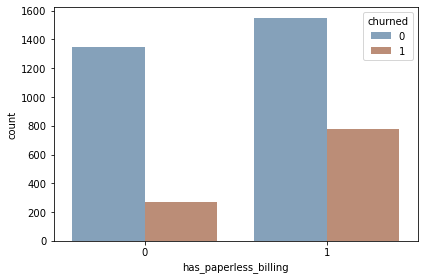

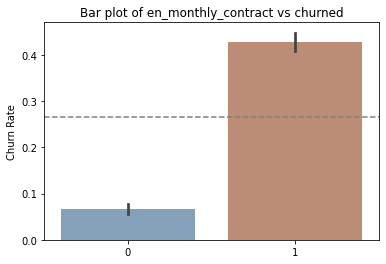

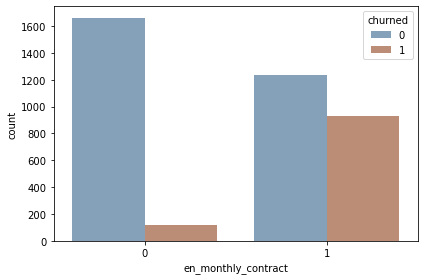

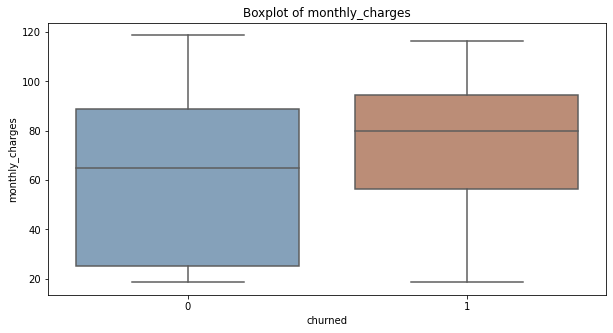

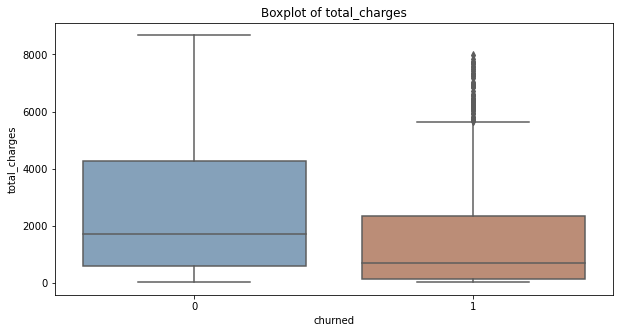

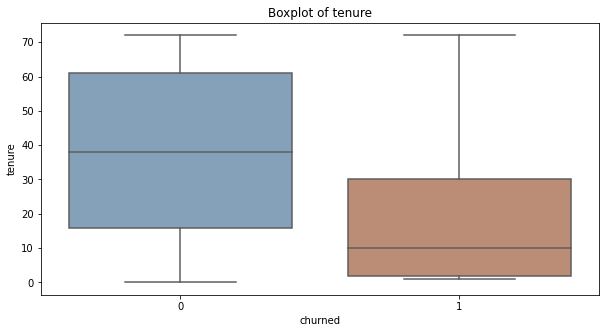

In [12]:
explore.explore_bivariate(train,'churned', cat_vars, quant_vars)


#### Bivariate Exploration Takeaways
- Customers using the following have the highest churn rate in their respective categories
   - Payment type 1 (e-check)
   - fiber optic internet 
   - paperless billing 
   - month-to-month contracts
- Senior citizens have comparatively higher churn rates than non-seniors
- In general, gender and the various premium services did not seem to have a huge difference in their churn rates
- There are outliers in total_charges for churned customers
- customers who churned, did so early in their tenure

### Exploring Multivariate Relationships

The explore_multivariate function in my explore script is used to generate boxplots showing customers who churned and didnt for each class of categorical variables against quantitatuve variables

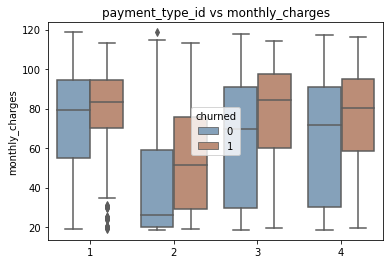

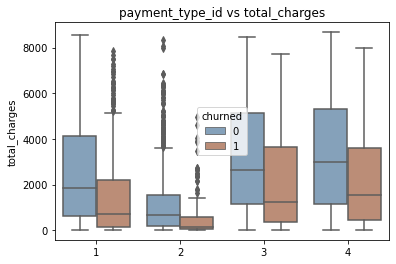

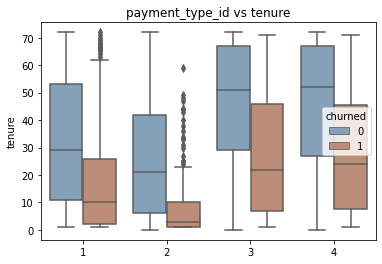

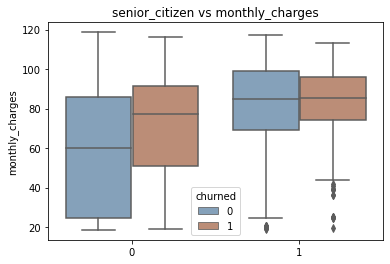

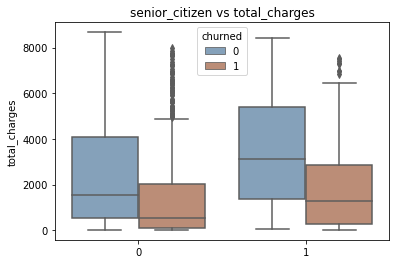

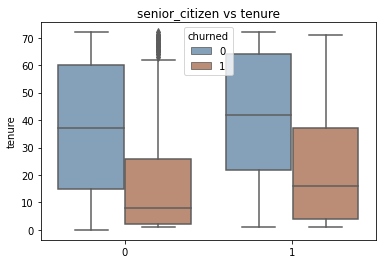

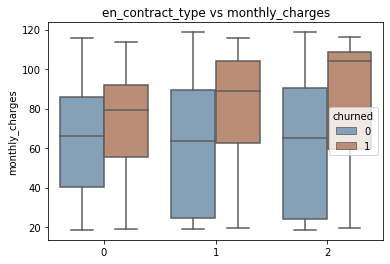

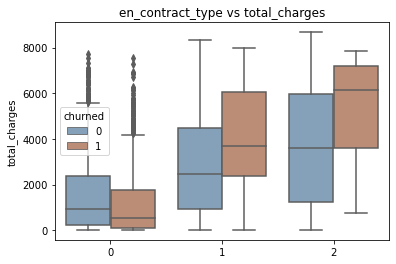

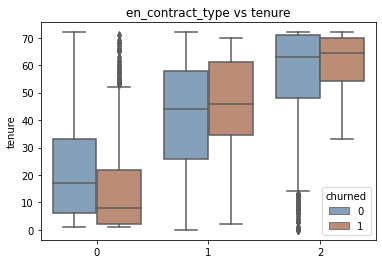

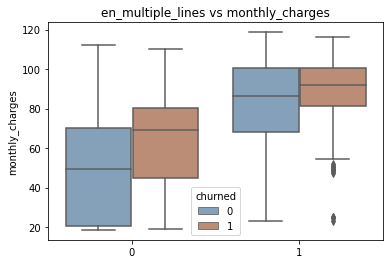

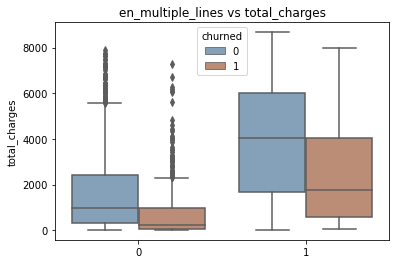

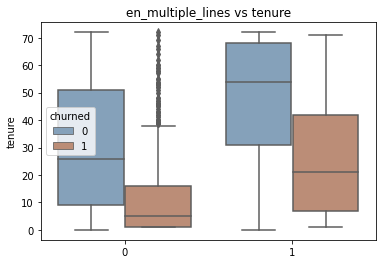

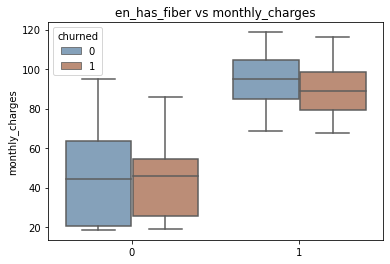

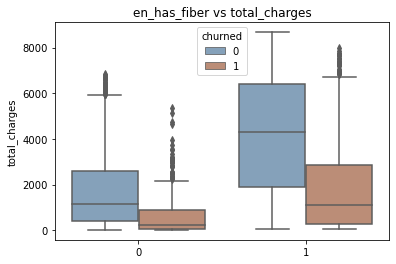

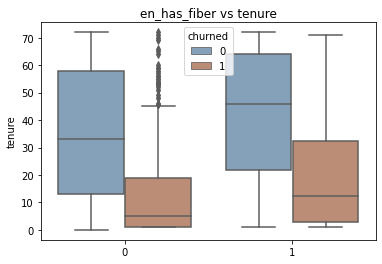

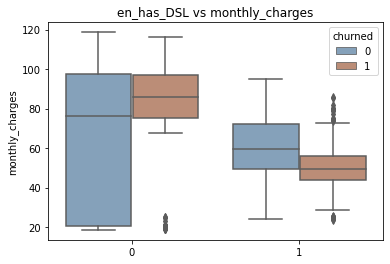

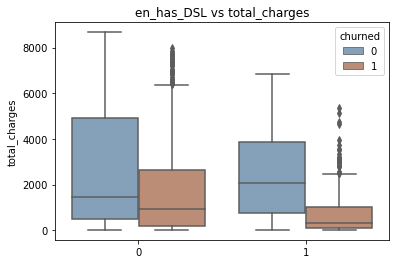

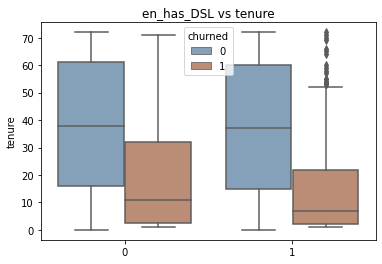

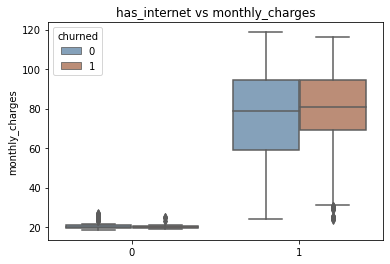

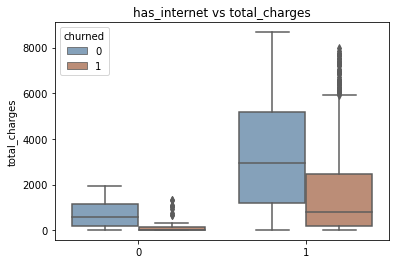

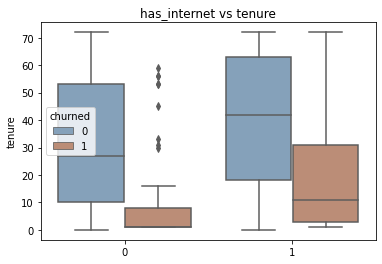

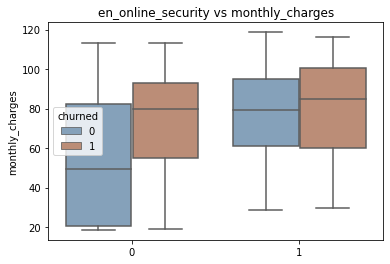

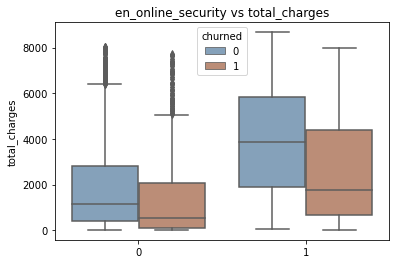

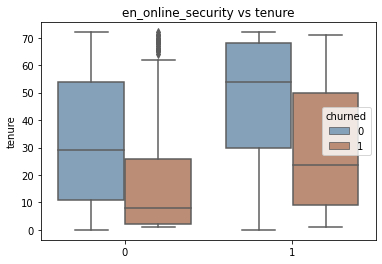

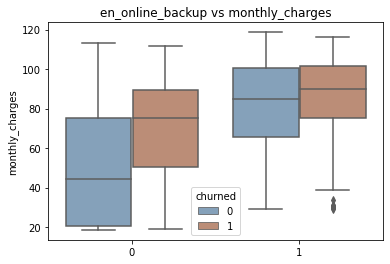

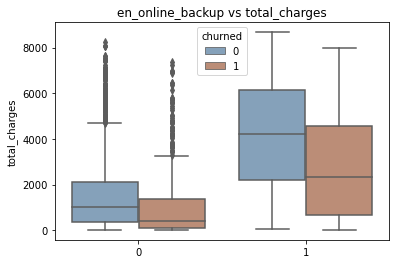

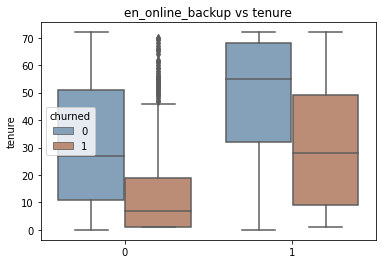

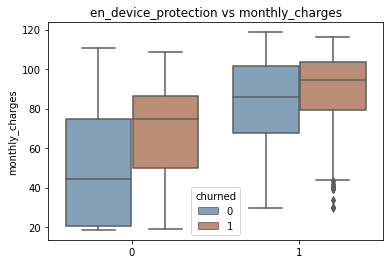

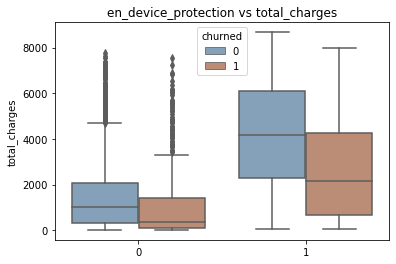

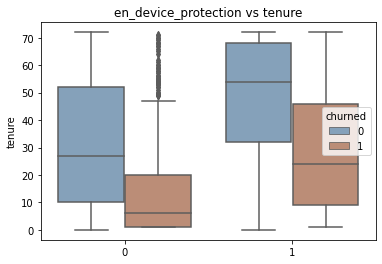

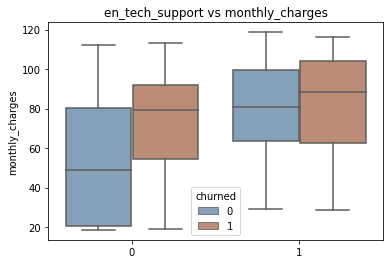

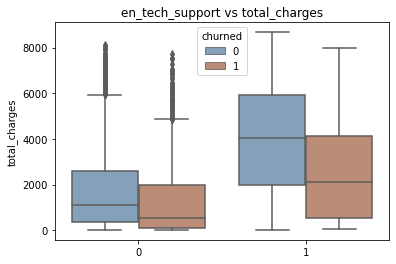

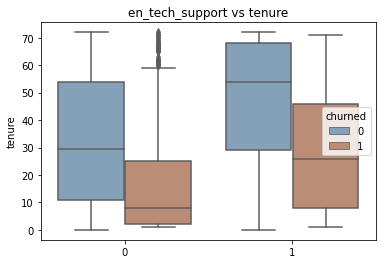

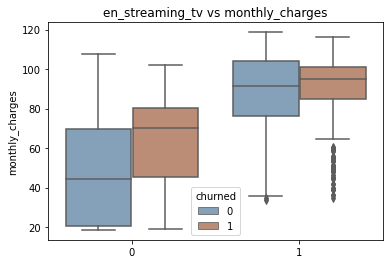

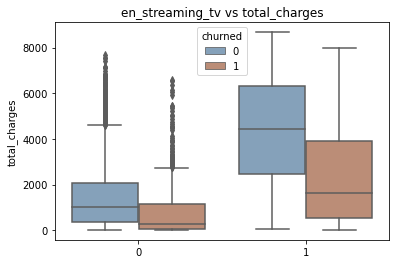

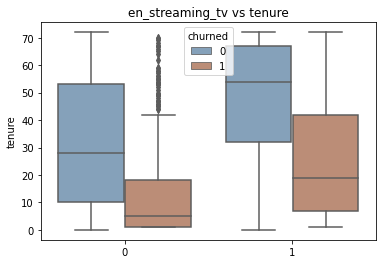

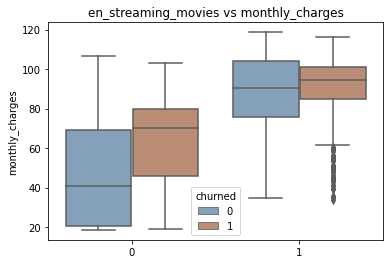

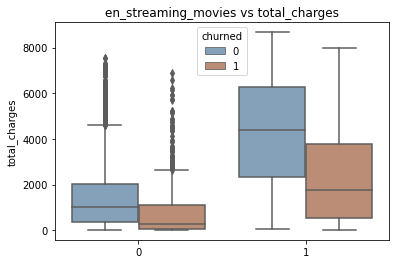

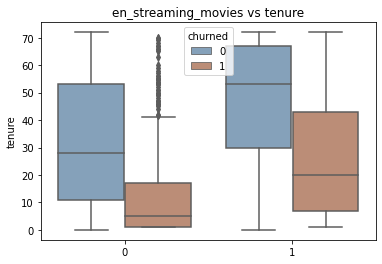

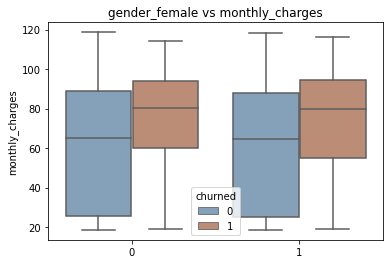

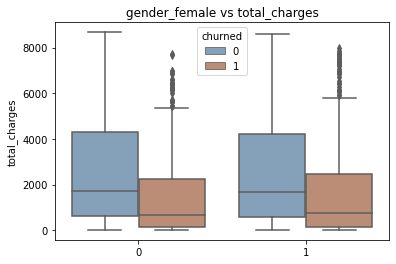

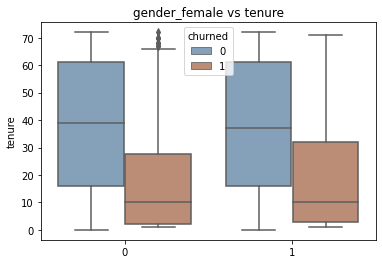

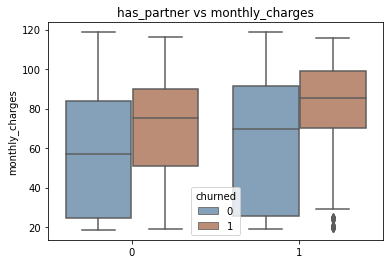

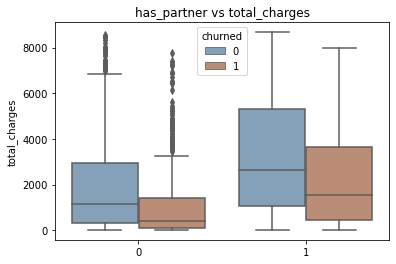

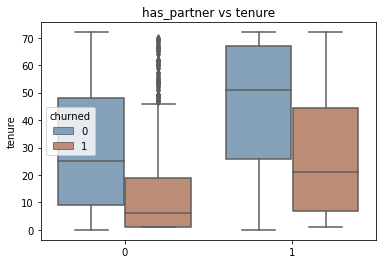

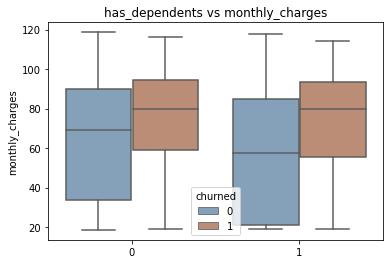

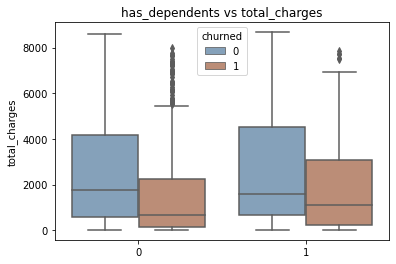

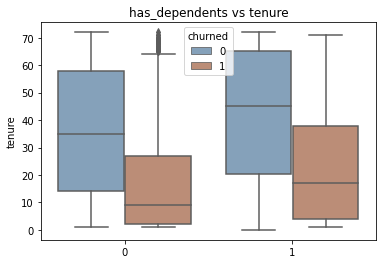

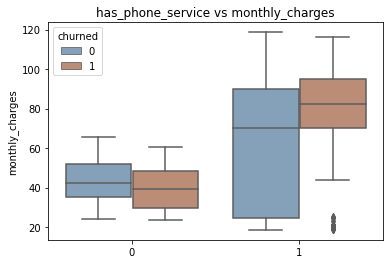

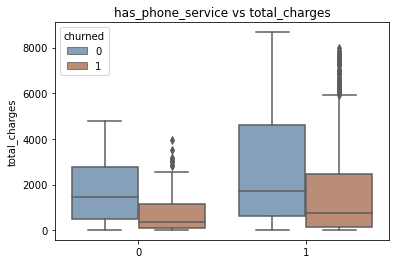

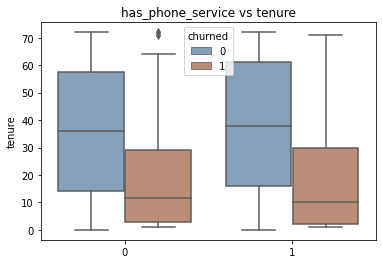

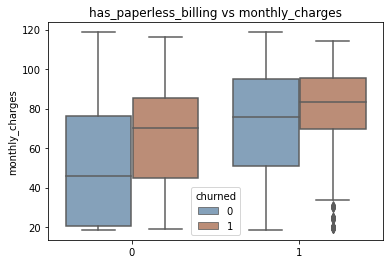

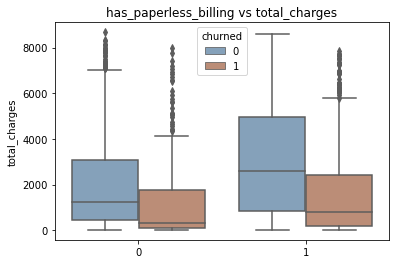

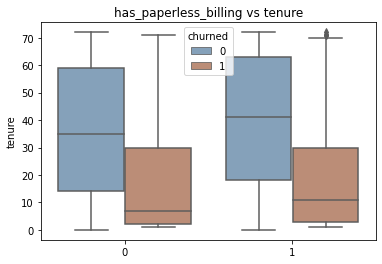

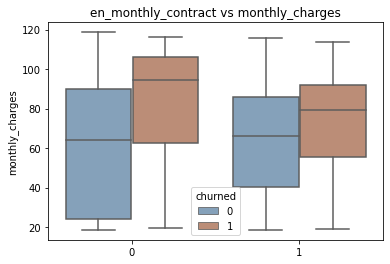

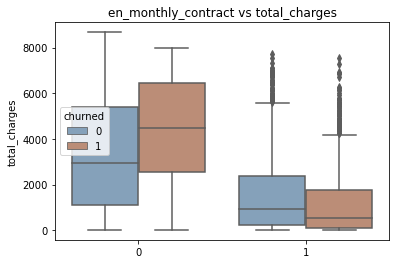

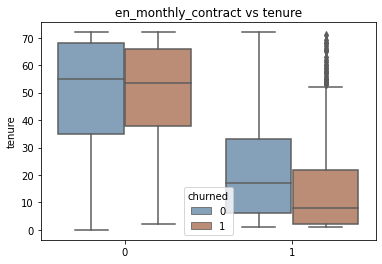

In [13]:
explore.explore_multivariate(train, 'churned', cat_vars, quant_vars)

#### Multivariate exploration Takeaways

   - Monthly charges higher for churning customers 
   - There are some outliers which could stand to be analyzed further
   - Month-to-month customers who churned had shortest tenures
   - Fiber customers had higher monthly charges than non fiber customers
   - Total charges is a function of tenure * monthly charges

<AxesSubplot:title={'center':'As tenure increases, churn rate decreases'}, xlabel='Tenure in months', ylabel='Churn Rate'>

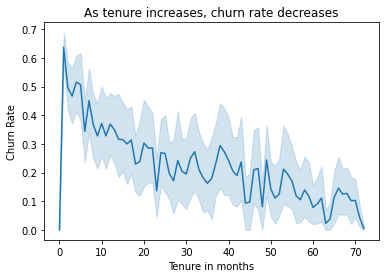

In [330]:
# visualizing churn rate on a lineplot
plt.title('As tenure increases, churn rate decreases')
plt.ylabel('Churn Rate')
plt.xlabel('Tenure in months')
sns.lineplot(x='tenure',y='churned', data=train)

### Lineplot Takeaways
    
  - Highest churn rate in the first few months of tenure
  - Churn rate is the lowest at the highest tenure
  - Churn rate reduces as tenure increase -  there are some increases at 24 and 40 -50 months tenure
      - These could be due to 2 year contract customers churning when their contract ends

# Statistical Analysis

> Based on my EDA, these are the features I would like to analyze further with hypothesis testing:
   >- monthly_charges
   >- en_has_fiber
   >- payment_type_id
   >- tenure 
   >- en_monthly_contract
    
Correlation, Chi square and t-tests were performed.
For all of the following statistical tests, a confidence level of 99% an alpha of 0.01 is used

Confidence level = 0.99

Alpha = 1 - Confidence level = 0.01


## Monthly Charges

- using a 1 sample 1 tailed t test
- For a 1-tailed test where our alternative hypothesis is testing for "greater than", we evaluate 𝑝/2 < 𝛼 and 𝑡 > 0.

### Setting Hypothesis
$H_{0}$: Mean monthly charges of customers who churned = Mean monthly charges of all customers

$H_{a}$: Mean monthly charges of customers who churned > Mean monthly charges of all customers

### Set Alpha
alpha =0.01

### Verify Assumptions
- Normal Distribution

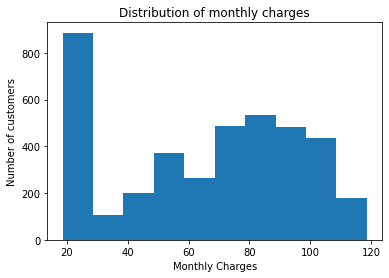

In [367]:
# plot distribution of monthly charges

plt.title('Distribution of monthly charges')
plt.xlabel('Monthly Charges')
plt.ylabel('Number of customers')
plt.hist(train.monthly_charges)
plt.show()

In [14]:
# check number of observations > 30 to meet normality assumption
print(train.monthly_charges.shape)

print(train.churned.value_counts())

(3943,)
0    2897
1    1046
Name: churned, dtype: int64


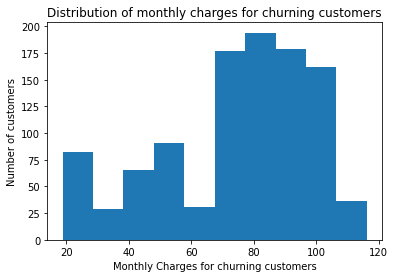

In [15]:
# plot distribution of montly charges for customer who churn

churn_sample = train[train.churned== 1].monthly_charges
churn_sample.hist()
plt.title('Distribution of monthly charges for churning customers')
plt.ylabel('Number of customers')
plt.xlabel('Monthly Charges for churning customers')
plt.grid(False)
plt.show()

<div class="alert alert-block alert-info"><b></b>  
    
Although the disttribtutions are not normal, the churn sample as well as the train split is large enough to meet the assumptions of normal distributions based on Central Limit Theorem.
</div>

In [355]:
# calculate t statistic and p value 
churn_sample = train[train.churned== 1].monthly_charges
overall_mean = train.monthly_charges.mean()
alpha = 0.01

t, p = stats.ttest_1samp(churn_sample, overall_mean)

t, p/2, alpha

(12.411208836102778, 2.1483628461896314e-33, 0.01)

In [356]:
if (p/2 < alpha) & (t > 0):
    print("We reject the null hypothesis.")
else:
    print("We fail to reject the null hypothesis.")

We reject the null hypothesis.


## Having Fiber Optic Internet

Chi sq test
- used to compare 2 categorical variables: en_has_fiber and churned

### Setting Hypothesis
$H_{0}$: Churn is independent of having fiber optic internet

$H_{a}$: Churn is not independent on having fiber optic internet

### Set Alpha
Confidence level = 0.99

Alpha = 1 - Confidence level = 0.01

### Verify Assumptions
- the samples are independent

In [17]:
# Create crosstab
observed = pd.crosstab(train.en_has_fiber, train.churned)
observed

churned,0,1
en_has_fiber,,
0,1881,322
1,1016,724


In [18]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [21]:
alpha = 0.01
print('Observed:\n')
print(observed)
print('~~~~~~~~~~~~~~~~~~~~~~')
print('Expected: \n')
print(pd.DataFrame(expected, index=observed.index, columns=observed.columns))
print('~~~~~~~~~~~~~~~~~~~~~~')
print(f'chi^2 value: {chi2:.4f}')
print(f'p value: {p}')
print(f'degrees of freedom: {degf}')
print('~~~~~~~~~~~~~~~~~~~~~~')
if p < alpha:
    print('''Our p value is less than our alpha and we can reject the null hypothesis.
We can suggest churn is not independent of having fiber optic internet''')
else:
    print('We cannot reject the null hypothesis')

Observed:

churned          0    1
en_has_fiber           
0             1881  322
1             1016  724
~~~~~~~~~~~~~~~~~~~~~~
Expected: 

churned                 0           1
en_has_fiber                         
0             1618.587624  584.412376
1             1278.412376  461.587624
~~~~~~~~~~~~~~~~~~~~~~
chi^2 value: 362.0332
p value: 1.0159095193215674e-80
degrees of freedom: 1
~~~~~~~~~~~~~~~~~~~~~~
Our p value is less than our alpha and we can reject the null hypothesis.
We can suggest churn is not independent of having fiber optic internet


## Payment Type

chi sq test
- used to compare 2 categorical variables: payment_type_id and churned

### Setting Hypothesis
$H_{0}$: Churn is independent of payment type

$H_{a}$: Churn is not independent of payment type

### Set Alpha
Confidence level = 0.99

Alpha = 1 - Confidence level = 0.01

### Verify Assumptions
- the samples are independent

In [22]:
# Create crosstab
observed = pd.crosstab(train.payment_type_id, train.churned)
observed

churned,0,1
payment_type_id,,
1,725,595
2,725,167
3,730,149
4,717,135


In [23]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [24]:
alpha = 0.01
print('Observed:\n')
print(observed)
print('~~~~~~~~~~~~~~~~~~~~~~')
print('Expected: \n')
print(pd.DataFrame(expected, index=observed.index, columns=observed.columns))
print('~~~~~~~~~~~~~~~~~~~~~~')
print(f'chi^2 value: {chi2:.4f}')
print(f'p value: {p:.8f}')
print(f'degrees of freedom: {degf}')
print('~~~~~~~~~~~~~~~~~~~~~~')
if p < alpha:
    print('''Our p value is less than our alpha and we can reject the null hypothesis.
We can suggest churn is not independent of payment type''')
else:
    print('We cannot reject the null hypothesis')

Observed:

churned            0    1
payment_type_id          
1                725  595
2                725  167
3                730  149
4                717  135
~~~~~~~~~~~~~~~~~~~~~~
Expected: 

churned                   0           1
payment_type_id                        
1                969.830079  350.169921
2                655.370023  236.629977
3                645.818666  233.181334
4                625.981233  226.018767
~~~~~~~~~~~~~~~~~~~~~~
chi^2 value: 352.1238
p value: 0.00000000
degrees of freedom: 3
~~~~~~~~~~~~~~~~~~~~~~
Our p value is less than our alpha and we can reject the null hypothesis.
We can suggest churn is not independent of payment type


## Tenure

Pearson's Correlation Test
- used to compare 2 continuous variables: tenure and monthly_charges

### Setting Hypothesis
$H_{0}$: There is no linear correlation between tenure and monthly charges.

$H_{a}$: There is a linear correlation between tenure and monthly charges.

### Set Alpha
Confidence level = 0.99

Alpha = 1 - Confidence level = 0.01

### Verify Assumptions
- Normal Distribution

In [25]:
# check number of observations
train.shape[0]


3943


Since the overall sample size is > 30, the assumption of normality is met based on CLT.


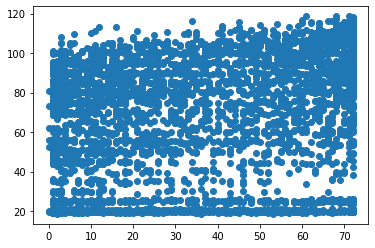

In [26]:
# visualize the distribution
x = train.tenure
y = train.monthly_charges
plt.scatter(x,y)

In [27]:
# this test returns the pearson's correlation r and a p -value
r, p = stats.pearsonr(train.tenure, train.monthly_charges)
r, p, alpha

(0.25085431465376695, 1.2072184567297247e-57, 0.01)

In [28]:
if p < alpha:
    print('''Our p value is less than alpha and we can reject the null hypothesis.
We can suggest there is a linear correlation between tenure and monthly charges''')
else:
    print('We cannot reject the null hypothesis')

Our p value is less than alpha and we can reject the null hypothesis.
We can suggest there is a linear correlation between tenure and monthly charges


## Month-to-Month Contract

- chi sq test

### Setting Hypothesis
$H_{0}$: Churn is independent of month to month contract

$H_{a}$: Churn is not independent of month to month contract

### Set Alpha
Confidence level = 0.99
Alpha = 1 - Confidence level = 0.01

### Verify Assumptions
- the samples are independent
- the sample size is large enough to assume normality

In [29]:
# Create crosstab
observed = pd.crosstab(train.en_monthly_contract, train.churned)
observed
# monthly contract customers who churned were about 8 times as many

churned,0,1
en_monthly_contract,,
0,1663,118
1,1234,928


In [30]:
chi2, p, degf, expected = stats.chi2_contingency(observed)

In [31]:
alpha = 0.01
print('Observed:\n')
print(observed)
print('~~~~~~~~~~~~~~~~~~~~~~')
print('Expected: \n')
print(pd.DataFrame(expected, index=observed.index, columns=observed.columns))
print('~~~~~~~~~~~~~~~~~~~~~~')
print(f'chi^2 value: {chi2:.4f}')
print(f'p value: {p}')
print(f'degrees of freedom: {degf}')
print('~~~~~~~~~~~~~~~~~~~~~~')
alpha = 0.01
if p < alpha:
    print('''Our p value is less than our alpha and we can reject the null hypothesis.
We can suggest churn is not independent of month to month contract''')
else:
    print('We cannot reject the null hypothesis')

Observed:

churned                 0    1
en_monthly_contract           
0                    1663  118
1                    1234  928
~~~~~~~~~~~~~~~~~~~~~~
Expected: 

churned                        0           1
en_monthly_contract                         
0                    1308.535886  472.464114
1                    1588.464114  573.535886
~~~~~~~~~~~~~~~~~~~~~~
chi^2 value: 658.2623
p value: 3.566417613179243e-145
degrees of freedom: 1
~~~~~~~~~~~~~~~~~~~~~~
Our p value is less than our alpha and we can reject the null hypothesis.
We can suggest churn is not independent of month to month contract


## Statistical Testing Takeaways
   
> Based on our alpha of 0.01, we can say that if these experiments were repeated multiple times, 99% of the times we would find that:
    >- The mean monthly charges for churning customers are significantly higher than the overall mean monthly charges
    >- Churn is not independent of having fiber optic internet
    >- Churn is not independent of payment type
    >- There is a linear correlation between tenure and monthly charges
    >- Churn is not independent of month-to-month contract

# Modeling

In this phase of the pipeline, I am using the models created below to predict customers who will churn. 
- A positive occurrence will be represented by a churned value of 1.
- A negative occurrence will be represented by a churned value of 1.

Outcomes:

FP: Predict that a customer will churn but they do not

FN: Predict that a customer will not churn but they do

TP: Predict that a customer will churn and they do

TN: Predict that a customer will not churn and they do not

The goal is to identify customers who are at risk of churning so my cost of false negative is higher than the cost of false positives. 
- I would rather include a customer who is unlikely to churn than miss a customer that may end up chruning. 
- The metric I will be considering will be the model's overall accuracy and the recall score.

Before I create the models, I want to explore which variables correlate highly with my target.

## Feature Selection

In [13]:
# correlation of features with the target variable
corr_churned = pd.DataFrame(train.corr().churned.sort_values(ascending=False)).reset_index().rename(columns={'churned':'correlation w/churned', 'index':'variable'})
corr_churned

,variable,correlation w/churned
0,churned,1.000000
1,en_monthly_contract,0.409166
2,en_has_fiber,0.303591
3,has_internet,0.223698
4,monthly_charges,0.189040
5,has_paperless_billing,0.187409
6,senior_citizen,0.165482
7,en_streaming_tv,0.069691
8,en_streaming_movies,0.062017
9,en_multiple_lines,0.041917


<AxesSubplot:>

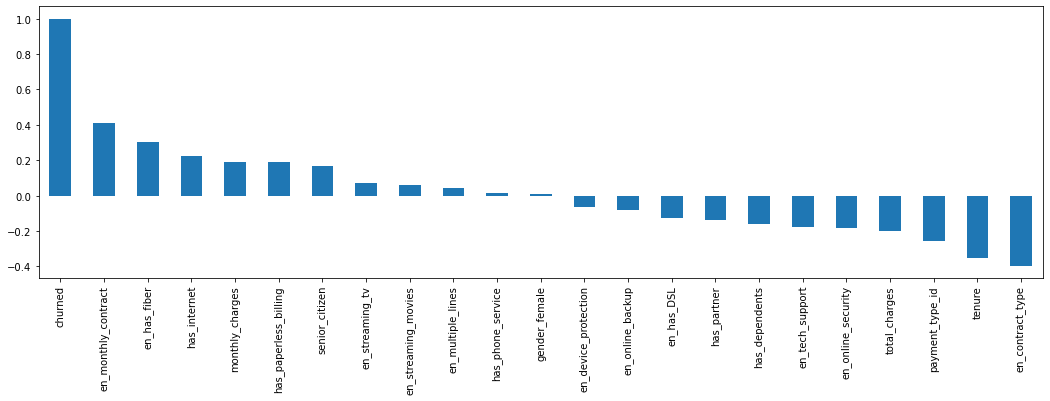

In [228]:
# this is a visualization of the predictors' correlation with the target variable of churn
train.corr().churned.sort_values(ascending=False).plot(kind='bar', figsize=(18,5))

### Feature Selection Takeaways
    
Highest correlation: -40% contract type
Lowest correlation: 0.7% gender_female

Contract_type, tenure, en_has_fiber, payment_type_id and has_internet have the highest correlations with churn in the train df

In my models, I want to focus on these features, as they have a high correlation with the predictor.


In [38]:
# based on the correlation and the statistical tests performed, I will be using the following features in my models

features=['en_monthly_contract','en_has_fiber','has_internet','monthly_charges','has_paperless_billing', 'senior_citizen',
'en_contract_type','tenure','payment_type_id','total_charges']

## Setup the Baseline

The baseline is set to be the most frequently occurring value in the training split. The baseline was set to be no churn or 0 in the churn column. The baseline accuracy was found to be 73.47%.

In [32]:
# finding the most common value for the target variable in the training split
train.churned.value_counts()

0    2897
1    1046
Name: churned, dtype: int64

In [33]:
# setting the baseline equal to no churn since there are most customers who don't churn
train['baseline'] = 0 

In [34]:
# calculating the baseline accuracy to compare our models to 
baseline_accuracy = (train.churned == train.baseline).mean()
print(f'The baseline accuracy is {baseline_accuracy:.2%}')

The baseline accuracy is 73.47%


In [35]:
# drop the baseline column from train df
train.drop(columns='baseline', inplace=True)

## Creating Models

- For all models I have used only the above mentioned features to predict churn
- Models created using Decision Tree, Random Forest, KNN and Logistic Regression Algorithms
- Models were fitted on train dataset and evaluated on validate split
- I will test only the best performing model based on overall accuracy and recall scores

### Model 1: Decision Tree 

In [36]:
# split our X and y

# in X_train, specify the independent variables
X_train = train.drop(columns='churned')

# in y_train, specify the dependent variable i.e. the variable that is being predicted
y_train = train[['churned']]

In [39]:
# 1. Create the model using all independent variables except customer id
clf1 = DecisionTreeClassifier(max_depth=10, random_state=123)

# 2. fit the model 
clf1.fit(X_train[features], y_train)

# 3. Make predictions using the same features
y_pred1 = clf1.predict(X_train[features])


In [40]:
accuracy1 = clf1.score(X_train[features], y_train)

# create the confusion matrix
conf1 = confusion_matrix(y_train, y_pred1)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred1, output_dict=True)).T
conf1 = confusion_matrix(y_train, y_pred1)

# true positive rate
tpr = conf1[1][1] / conf1[1].sum()

# false positive rate
fpr = conf1[0][1] / conf1[0].sum()

# true negative rate
tnr = conf1[0][0] / conf1[0].sum()

# false negative rate
fnr = conf1[1][0] / conf1[1].sum()

print(f'''
The accuracy for our model is {accuracy1:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8818
The True Positive Rate is 0.754, The False Positive Rate is 0.0721,
The True Negative Rate is 0.928, and the False Negative Rate is 0.246



,precision,recall,f1-score,support
0,0.912733,0.927856,0.920233,2897.000000
1,0.790581,0.754302,0.772016,1046.000000
accuracy,0.881816,0.881816,0.881816,0.881816
macro avg,0.851657,0.841079,0.846124,3943.000000
weighted avg,0.880329,0.881816,0.880914,3943.000000


>**Model 1** has an overall accuracy of 88% and a recall score of 75%. This model beats our baseline of 73%.

### Model 2: Random Forest 

In [41]:
# Create the model
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=1,
                            n_estimators=100,
                            max_depth=10, 
                            random_state=123)

In [42]:
# fit model to training data
rf.fit(X_train[features], y_train)

RandomForestClassifier(max_depth=10, random_state=123)

In [43]:
# 3. Make predictions using the same features
y_pred2 = rf.predict(X_train[features])

In [45]:
accuracy2 = rf.score(X_train[features], y_train)

# create the confusion matrix
conf2 = confusion_matrix(y_train, y_pred2)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred2, output_dict=True)).T
conf2 = confusion_matrix(y_train, y_pred2)

# true positive rate
tpr = conf2[1][1] / conf2[1].sum()

# false positive rate
fpr = conf2[0][1] / conf2[0].sum()

# true negative rate
tnr = conf2[0][0] / conf2[0].sum()

# false negative rate
fnr = conf2[1][0] / conf2[1].sum()

print(f'''
The accuracy for our model is {accuracy2:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8902
The True Positive Rate is 0.729, The False Positive Rate is 0.0518,
The True Negative Rate is 0.948, and the False Negative Rate is 0.271



,precision,recall,f1-score,support
0,0.906601,0.948222,0.926944,2897.000000
1,0.835706,0.729446,0.778969,1046.000000
accuracy,0.890185,0.890185,0.890185,0.890185
macro avg,0.871154,0.838834,0.852957,3943.000000
weighted avg,0.887794,0.890185,0.887689,3943.000000


>**Model 2** has a higher overall accuracy of 89% compared to model 1 (88%); this also beats the baseline accuracy of 73%. The false negative rate is low at 27% and the recall score of 73%  is higher than that of model 1.

### Model 3: KNN


In [46]:
# Create the model
knn = KNeighborsClassifier(n_neighbors=6)

In [48]:
# fit the model on train data
knn.fit(X_train[features], y_train)

KNeighborsClassifier(n_neighbors=6)

In [49]:
# make predictions using the model
y_pred3 = knn.predict(X_train[features])

In [50]:
accuracy3 = knn.score(X_train[features], y_train)

# create the confusion matrix
conf3 = confusion_matrix(y_train, y_pred3)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred3, output_dict=True)).T
conf3 = confusion_matrix(y_train, y_pred3)

# true positive rate
tpr = conf3[1][1] / conf3[1].sum()

# false positive rate
fpr = conf3[0][1] / conf3[0].sum()

# true negative rate
tnr = conf3[0][0] / conf3[0].sum()

# false negative rate
fnr = conf3[1][0] / conf3[1].sum()

print(f'''
The accuracy for our model is {accuracy3:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8217
The True Positive Rate is 0.445, The False Positive Rate is 0.0421,
The True Negative Rate is 0.958, and the False Negative Rate is 0.555



,precision,recall,f1-score,support
0,0.826877,0.957887,0.887574,2897.000000
1,0.792164,0.444551,0.569504,1046.000000
accuracy,0.821709,0.821709,0.821709,0.821709
macro avg,0.809520,0.701219,0.728539,3943.000000
weighted avg,0.817668,0.821709,0.803196,3943.000000


>**Model 3** has an overall accuracy of 82% which is lower than Models 1 & 2; but this model also beats the baseline accuracy of 73.47%. The false negative rate is more than 50% and the recall score is 44%. 

### Model 4: Logistic Regression 

In [51]:
# create the model
logit = LogisticRegression(C=1, class_weight=None, 
                            random_state=123)

In [52]:
# fit the model 
logit.fit(X_train[features], y_train)

LogisticRegression(C=1, random_state=123)

In [53]:
# make predictions
y_pred4 = logit.predict(X_train[features])

In [54]:
accuracy4 = logit.score(X_train[features], y_train)

# create the confusion matrix
conf4 = confusion_matrix(y_train, y_pred4)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred4, output_dict=True)).T
conf4 = confusion_matrix(y_train, y_pred4)

# true positive rate
tpr = conf4[1][1] / conf4[1].sum()

# false positive rate
fpr = conf4[0][1] / conf4[0].sum()

# true negative rate
tnr = conf4[0][0] / conf4[0].sum()

# false negative rate
fnr = conf4[1][0] / conf4[1].sum()

print(f'''
The accuracy for our model is {accuracy4:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.7951
The True Positive Rate is 0.496, The False Positive Rate is 0.097,
The True Negative Rate is 0.903, and the False Negative Rate is 0.504



,precision,recall,f1-score,support
0,0.832326,0.903003,0.866225,2897.00000
1,0.648750,0.496176,0.562297,1046.00000
accuracy,0.795080,0.795080,0.795080,0.79508
macro avg,0.740538,0.699590,0.714261,3943.00000
weighted avg,0.783627,0.795080,0.785599,3943.00000


>**Model 4** has an overall accuracy of 80% which is lower than the previous models. This model, like all the other models, also beats our baseline of 73%. Model 4 has a recall score of 50% which is lower than Models 1 and 2 but slightly higher than Model 3.

## Fine tuning hyperparameters 

I will adjust hyperparameters for Models 1 and 2 to check if accuracy and recall scores improve.

### Tuning Model 1

In [55]:
# split our X and y

# in X_train, specify all the independent variables
X_train = train.drop(columns='churned')

# in y_train, specify the dependent variable i.e. the variable that is being predicted
y_train = train[['churned']]

In [56]:
# using the same features as in the models earlier 
features = ['en_monthly_contract','en_has_fiber','has_internet','monthly_charges','has_paperless_billing', 'senior_citizen',
'en_contract_type','tenure','payment_type_id','total_charges']

In [57]:
# 1. Create the model using our independent variables specified in features
# increase max depth to 20 to check effect on model performance
clf1_ft = DecisionTreeClassifier(max_depth=20, random_state=123)

# 2. fit the model 
clf1_ft.fit(X_train[features], y_train)

DecisionTreeClassifier(max_depth=20, random_state=123)

In [58]:
# 3. Make predictions using the same features
y_pred1 = clf1_ft.predict(X_train[features])

In [59]:
accuracy_ft1 = clf1_ft.score(X_train[features], y_train)
# create the confusion matrix
conf_ft1 = confusion_matrix(y_train, y_pred1)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred1, output_dict=True)).T
conf_ft1 = confusion_matrix(y_train, y_pred1)

# true positive rate
tpr = conf_ft1[1][1] / conf_ft1[1].sum()

# false positive rate
fpr = conf_ft1[0][1] / conf_ft1[0].sum()

# true negative rate
tnr = conf_ft1[0][0] / conf_ft1[0].sum()

# false negative rate
fnr = conf_ft1[1][0] / conf_ft1[1].sum()

print(f'''
The accuracy for our model is {accuracy_ft1:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.983
The True Positive Rate is 0.982, The False Positive Rate is 0.0166,
The True Negative Rate is 0.983, and the False Negative Rate is 0.0182



,precision,recall,f1-score,support
0,0.993375,0.983431,0.988378,2897.000000
1,0.955349,0.981836,0.968411,1046.000000
accuracy,0.983008,0.983008,0.983008,0.983008
macro avg,0.974362,0.982633,0.978395,3943.000000
weighted avg,0.983288,0.983008,0.983081,3943.000000


>Accuracy and recall scores have both increased to over 98% which might indicate this model being overfit. This will be verified in validation.

### Tuning Model 2

Changing class weight to balanced
Increasing min samples leaf to 3 and max depth to 15

In [60]:
# Create the model
rf_ft = RandomForestClassifier(bootstrap=True, 
                            class_weight='balanced', 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=15, 
                            random_state=123)

# fit model to training data
rf_ft.fit(X_train[features], y_train)

RandomForestClassifier(class_weight='balanced', max_depth=15,
                       min_samples_leaf=3, random_state=123)

In [61]:
# 3. Make predictions using the same features
y_pred2 = rf_ft.predict(X_train[features])

In [62]:
accuracy_ft2 = rf_ft.score(X_train[features], y_train)

# create the confusion matrix
conf_ft2 = confusion_matrix(y_train, y_pred2)

# creating the classification report and transposing it
class_report = pd.DataFrame(classification_report(y_train, y_pred2, output_dict=True)).T
conf_ft2 = confusion_matrix(y_train, y_pred2)

# true positive rate
tpr = conf_ft2[1][1] / conf_ft2[1].sum()

# false positive rate
fpr = conf_ft2[0][1] / conf_ft2[0].sum()

# true negative rate
tnr = conf_ft2[0][0] / conf_ft2[0].sum()

# false negative rate
fnr = conf_ft2[1][0] / conf_ft2[1].sum()

print(f'''
The accuracy for our model is {accuracy_ft2:.4}
The True Positive Rate is {tpr:.3}, The False Positive Rate is {fpr:.3},
The True Negative Rate is {tnr:.3}, and the False Negative Rate is {fnr:.3}
''')
class_report


The accuracy for our model is 0.8922
The True Positive Rate is 0.912, The False Positive Rate is 0.115,
The True Negative Rate is 0.885, and the False Negative Rate is 0.088



,precision,recall,f1-score,support
0,0.965361,0.885054,0.923465,2897.000000
1,0.741259,0.912046,0.817831,1046.000000
accuracy,0.892214,0.892214,0.892214,0.892214
macro avg,0.853310,0.898550,0.870648,3943.000000
weighted avg,0.905911,0.892214,0.895442,3943.000000


>Accuracy stayed the same at 89% but recall increased to 91%

## Evaluating the Models 
Use the fine tuned models 1 and 2 and other models to evaluate on out of sample data

### Checking Fine Tuned Model 1

In [64]:
# split our X and y for the validate dataset
X_validate = validate.drop(columns=['churned', 'customer_id'])
y_validate = validate[['churned']]

In [65]:
# using the features specified earlier in the first model
y_pred_val1_ft = clf1_ft.predict(X_validate[features])

In [66]:
#classification report
print(classification_report(y_validate, y_pred_val1_ft))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1242
           1       0.48      0.49      0.48       449

    accuracy                           0.72      1691
   macro avg       0.65      0.65      0.65      1691
weighted avg       0.73      0.72      0.72      1691



>Huge drop in overall accuracy and recall score indicate that fine tuned model 1 was overfit. We will not be utilizing this model.

### Checking Fine Tuned Model 2

In [67]:
# using all the features in the first model
y_pred_val2_ft = rf_ft.predict(X_validate[features])

In [68]:
#classification report
print(classification_report(y_validate, y_pred_val2_ft))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84      1242
           1       0.56      0.65      0.60       449

    accuracy                           0.77      1691
   macro avg       0.71      0.73      0.72      1691
weighted avg       0.78      0.77      0.78      1691



>Huge drop in overall accuracy and recall score indicates this fine tuned model was possibly overfit too. 

### Checking original Model 1

In [69]:
# using all the features in the first model
y_pred_val1 = clf1_ft.predict(X_validate[features])

In [70]:
#classification report
print(classification_report(y_validate, y_pred_val1))

              precision    recall  f1-score   support

           0       0.81      0.81      0.81      1242
           1       0.48      0.49      0.48       449

    accuracy                           0.72      1691
   macro avg       0.65      0.65      0.65      1691
weighted avg       0.73      0.72      0.72      1691



### Checking original Model 2

In [71]:
# using all the features in the first model
y_pred_val2 = rf.predict(X_validate[features])

In [72]:
#classification report
print(classification_report(y_validate, y_pred_val2))

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1242
           1       0.63      0.51      0.56       449

    accuracy                           0.79      1691
   macro avg       0.73      0.70      0.71      1691
weighted avg       0.78      0.79      0.78      1691



>Accuracy and recall scores dropped from 89% to 79% and 73% to 51% respectively. This large decrease in accuracy and recall scores on the validate split indicates the model might have been overfit. 

### Checking original Model 3

In [73]:
# using all the features in the first model
y_pred_val3 = knn.predict(X_validate[features])

In [74]:
#classification report
print(classification_report(y_validate, y_pred_val3))

              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1242
           1       0.61      0.36      0.45       449

    accuracy                           0.77      1691
   macro avg       0.70      0.64      0.65      1691
weighted avg       0.75      0.77      0.75      1691



>Accuracy and recall scores dropped from 82% to 77% and 44% to 36% respectively. The recall score shows a larger drop on the validate split than the overall acccuracy score compared to the train dataset.

### Checking original Model 4

In [77]:
# using all the features in the first model
y_pred_val4 = logit.predict(X_validate[features])

In [78]:
#classification report
print(classification_report(y_validate, y_pred_val4))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1242
           1       0.66      0.50      0.57       449

    accuracy                           0.80      1691
   macro avg       0.75      0.70      0.72      1691
weighted avg       0.79      0.80      0.79      1691



>**Model 4** performs the best on out of sample data despite not having the highest overall accuracy on in sample data. This model has very similar accuracy and recall scores between train and validate splits.

### Modeling Takeaways

- I fine tuned Decision Tree model by increasing max_depth to 20
     - This model gave me over 98% accuracy and recall scores which indicates they are likely overfit
         - This was confirmed by overall accuracy and recall scores dropping greatly on the validate dataset
- I tuned hyperparameters for model 2 by increasing max depth and min samples leaf as well as using balanced class weights
    - This also caused a huge drop in overall accuracy and recall scores on the validate dataset
- All models beat my baseline accuracy of 73.47%
- My best performing model is the Logistic Regression Model
    - Overall accuracy of 79.51% and recall of 49.6% on train data
    - Overall accuracy of 80% and recall of 50% on validate data
    > This model does not have the highest overall accuracy and recall scores on in sample data but it has the smallest drop between scores on train and validate splits

### Testing My Best Model

- I will only test my best performing model which is model 4 on the test data.
- The same features that have been utilized so far will be fed into the test model

In [36]:
X_test = test.drop(columns=['churned', 'customer_id'])

In [37]:
y_test = test.churned
predicted_test = logit.predict(X_test[features])
print(classification_report(y_test, predicted_test))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1035
           1       0.66      0.50      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.70      0.72      1409
weighted avg       0.79      0.80      0.79      1409



>Accuracy is 80% and recall is 50% which is about the same as scores on the train and validate splits. 

# Create Predictions CSV

The predictions csv file <a href="https://github.com/mariamnaqvi/predicting_customer_churn/blob/main/predictions.csv">here</a> shows the customer id, probability of churn and the model's prediction.

Churn = 0 means a customer will not churn 

Churn = 1 means  a customer will churn


In [38]:
proba_test = logit.predict_proba(X_test[features])

In [48]:
# create df with churn and no churn columns and their probabilities
proba_df = pd.DataFrame(proba_test, columns=logit.classes_.tolist()).rename(columns=({0:'P(No Churn)', 1:'P(Churn)'}))
proba_df.head()

,P(No Churn),P(Churn)
0,0.959323,0.040677
1,0.688260,0.311740
2,0.744790,0.255210
3,0.841058,0.158942
4,0.660742,0.339258


In [49]:
# resetting the index
reset_test = test.reset_index()
reset_test.head()

,index,payment_type_id,customer_id,senior_citizen,tenure,monthly_charges,total_charges,en_contract_type,en_monthly_contract,en_multiple_lines,...,en_device_protection,en_tech_support,en_streaming_tv,en_streaming_movies,gender_female,has_partner,has_dependents,has_phone_service,has_paperless_billing,churned
0,2789,3,8670-ERCJH,0,72,113.40,8164.10,2,0,1,...,1,1,1,1,1,0,0,1,0,0
1,1233,3,0356-ERHVT,0,11,45.90,521.90,0,1,0,...,0,0,0,0,1,1,0,1,1,0
2,6784,2,4786-UKSNZ,0,1,20.20,20.20,0,1,0,...,0,0,0,0,1,0,0,1,0,1
3,3177,1,5945-AZYHT,0,71,109.60,7854.15,1,0,1,...,1,0,1,1,1,1,0,1,1,0
4,1740,2,4432-ADRLB,0,2,44.65,74.90,0,1,0,...,0,0,0,0,1,0,0,1,0,1


In [50]:
# concatenate the probability of churn/no curn df created above
test_proba_df = pd.concat([reset_test, proba_df], axis=1)

# look at the first 5 rows
test_proba_df.head()

,index,payment_type_id,customer_id,senior_citizen,tenure,monthly_charges,total_charges,en_contract_type,en_monthly_contract,en_multiple_lines,...,en_streaming_tv,en_streaming_movies,gender_female,has_partner,has_dependents,has_phone_service,has_paperless_billing,churned,P(No Churn),P(Churn)
0,2789,3,8670-ERCJH,0,72,113.40,8164.10,2,0,1,...,1,1,1,0,0,1,0,0,0.959323,0.040677
1,1233,3,0356-ERHVT,0,11,45.90,521.90,0,1,0,...,0,0,1,1,0,1,1,0,0.688260,0.311740
2,6784,2,4786-UKSNZ,0,1,20.20,20.20,0,1,0,...,0,0,1,0,0,1,0,1,0.744790,0.255210
3,3177,1,5945-AZYHT,0,71,109.60,7854.15,1,0,1,...,1,1,1,1,0,1,1,0,0.841058,0.158942
4,1740,2,4432-ADRLB,0,2,44.65,74.90,0,1,0,...,0,0,1,0,0,1,0,1,0.660742,0.339258


In [51]:
# add a new column for my predictions
test_proba_df['prediction'] = predicted_test
test_proba_df.head()

,index,payment_type_id,customer_id,senior_citizen,tenure,monthly_charges,total_charges,en_contract_type,en_monthly_contract,en_multiple_lines,...,en_streaming_movies,gender_female,has_partner,has_dependents,has_phone_service,has_paperless_billing,churned,P(No Churn),P(Churn),prediction
0,2789,3,8670-ERCJH,0,72,113.40,8164.10,2,0,1,...,1,1,0,0,1,0,0,0.959323,0.040677,0
1,1233,3,0356-ERHVT,0,11,45.90,521.90,0,1,0,...,0,1,1,0,1,1,0,0.688260,0.311740,0
2,6784,2,4786-UKSNZ,0,1,20.20,20.20,0,1,0,...,0,1,0,0,1,0,1,0.744790,0.255210,0
3,3177,1,5945-AZYHT,0,71,109.60,7854.15,1,0,1,...,1,1,1,0,1,1,0,0.841058,0.158942,0
4,1740,2,4432-ADRLB,0,2,44.65,74.90,0,1,0,...,0,1,0,0,1,0,1,0.660742,0.339258,0


## Predictions.csv file

In [52]:
csv_df = test_proba_df[['customer_id', 'P(Churn)', 'prediction']]
csv_df.head()

,customer_id,P(Churn),prediction
0,8670-ERCJH,0.040677,0
1,0356-ERHVT,0.311740,0
2,4786-UKSNZ,0.255210,0
3,5945-AZYHT,0.158942,0
4,4432-ADRLB,0.339258,0


In [53]:
# Write DataFrame to a csv file for deliverable.

csv_df.to_csv('predictions.csv')

# Conclusion & Next Steps

- My Logistic Regression Model will predict customers at risk of churning with 80% accuracy.
- If I had more time, I would:
    - explore the outliers in more detail
    - examine factors leading to customers with higher monthly charges staying for longer tenures 
    - explore premium services and their effect on churn more
